This notebook presents the analysis for the case of 41-1 where different analysis for veiligheidsrendement were conducted with and without Sluis Weurt. 
It is an example of how different veiligheidsrendement runs in the same database can be compared.

### Import necessary libraries

In [1]:
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import numpy as np
from scipy.stats import norm
from peewee import fn

from vrtool.orm.models import *
from vrtool.orm.orm_controllers import open_database
from vrtool.common.enums import MechanismEnum
from postprocessing.database_analytics import *
from postprocessing.database_access_functions import * 
from postprocessing.generate_output import *

sns.set(style="whitegrid")



### Get the runs that are in the database
First we get an overview of the runs in the database

In [2]:
database_path = Path(r'c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_Samenwerken aan Kunstwerken\Testcases\41-1_compleet\41-1_met_weurt_nieuw.db')
run_list = get_overview_of_runs(database_path)

pd.DataFrame(run_list)

,id,name,discount_rate,optimization_type,optimization_type_name
0,1,Met sluis Weurt Veiligheidsrendement,0.03,1,VEILIGHEIDSRENDEMENT
1,2,Zonder sluis Weurt Veiligheidsrendement,0.03,1,VEILIGHEIDSRENDEMENT
2,3,Sluis Weurt in 2045 Veiligheidsrendement,0.03,1,VEILIGHEIDSRENDEMENT


For each run, we get the optimization steps

In [3]:
optimization_steps = {run['name']: get_optimization_steps_for_run_id(database_path, run['id']) for run in run_list}
# add total cost as sum of total_lcc and total_risk in each step

minimal_tc_steps = {run: get_minimal_tc_step(steps) for run, steps in optimization_steps.items()}


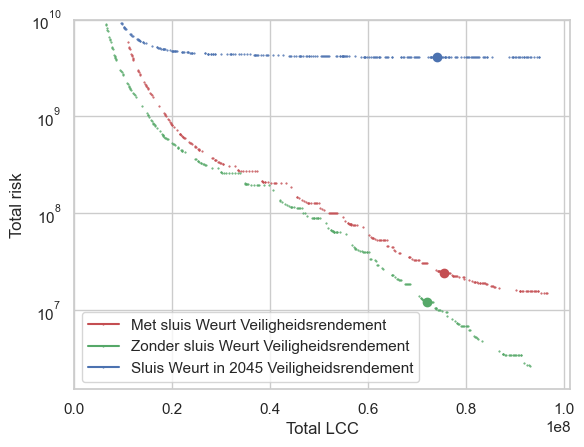

In [4]:
fig, ax = plt.subplots()
colors = ['r', 'g', 'b']
for run in optimization_steps.keys():
    plot_lcc_tc_from_steps(optimization_steps[run], axis=ax, lbl  = run, clr = colors[0])
    ax.plot(optimization_steps[run][minimal_tc_steps[run]]['total_lcc'], optimization_steps[run][minimal_tc_steps[run]]['total_risk'], 'o', color = colors.pop(0))
ax.set_xlabel('Total LCC')
ax.set_ylabel('Total risk')
ax.set_yscale('log')
ax.set_xlim(left=0)
ax.set_ylim(top=1e10)
ax.legend()

We see that without sluis Weurt the risk is lower than with, because we assume that the lock can fail. If we take it into account, we get into a very suboptimal solution if we do not reinforce it in 2025 (but in 2045).

### Reading measures per step
The next step is to read the measures and parameters of these measures for each optimization step such that we can compare the measures that are taken in each step and for each section.

In [5]:
lists_of_measures = {run['id']: get_measures_for_run_id(database_path, run['id']) for run in run_list}

measures_per_step = {run['id']: get_measures_per_step_number(lists_of_measures[run['id']]) for run in run_list}

If we want to see the failure probability per stap we first need to load the original assessment for each mechanism, and then we can compute the reliability for each step during the optimization. 

In [6]:
assessment_results = {mechanism: import_original_assessment(database_path, mechanism) 
                      for mechanism in [MechanismEnum.OVERFLOW, MechanismEnum.PIPING, MechanismEnum.STABILITY_INNER]}

reliability_per_step = {run['id']: get_reliability_for_each_step(database_path, measures_per_step[run['id']]) for run in run_list}

Based on these inputs we can make a stepwise_assessment based on the investments in reliability_per_step

In [7]:
stepwise_assessment = {run['id']: assessment_for_each_step(copy.deepcopy(assessment_results), reliability_per_step[run['id']]) for run in run_list}

The next step is to derive the traject probability for each mechanism for each step using the `calculate_traject_probability_for_steps` function

In [8]:
traject_prob = {run['id']: calculate_traject_probability_for_steps(stepwise_assessment[run['id']]) for run in run_list}

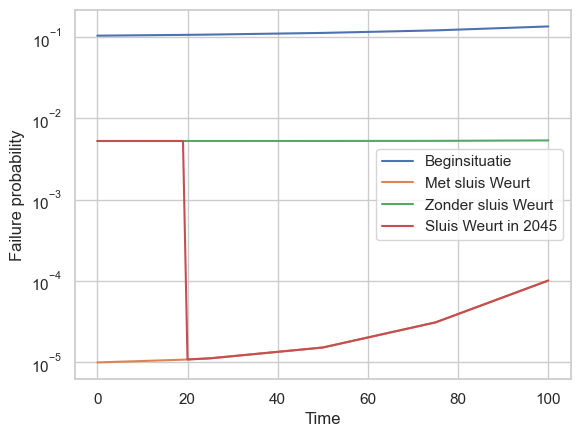

In [9]:
fig, ax  = plt.subplots()

plot_traject_probability_for_step(traject_prob[1][0], ax, run_label='Beginsituatie')
plot_traject_probability_for_step(traject_prob[1][minimal_tc_steps['Met sluis Weurt Veiligheidsrendement']], ax, run_label='Met sluis Weurt')
plot_traject_probability_for_step(traject_prob[2][minimal_tc_steps['Zonder sluis Weurt Veiligheidsrendement']], ax, run_label='Zonder sluis Weurt')
plot_traject_probability_for_step(traject_prob[3][minimal_tc_steps['Sluis Weurt in 2045 Veiligheidsrendement']], ax, run_label='Sluis Weurt in 2045')


Check the measures for each section

In [10]:
def get_measures_per_section_for_step(measures_per_step, final_step_no):
    measures_per_section = {}
    for step_no, step in measures_per_step.items():
        if step_no <= final_step_no:
            if step['section_id'][0] not in measures_per_section:
                measures_per_section[step['section_id'][0]] = []
            measures_per_section[step['section_id'][0]] = (step['measure_result'], step['investment_year'])
    return dict(sorted(measures_per_section.items()))

measures_per_section = {run['id']: get_measures_per_section_for_step(measures_per_step[run['id']], minimal_tc_steps['Met sluis Weurt Veiligheidsrendement']) for run in run_list}

for section in measures_per_section[1].keys():
    for run in measures_per_section.keys():
        try:
            print(f"Section {section} in run {run} has measures {measures_per_section[run][section]}")  
        except:
            print(f"Section {section} in run {run} has no measures in run {run}")

Section 1 in run 1 has measures ([25], [0])
Section 1 in run 2 has measures ([25], [0])
Section 1 in run 3 has measures ([25], [0])
Section 2 in run 1 has measures ([185], [0])
Section 2 in run 2 has measures ([185], [0])
Section 2 in run 3 has measures ([185], [0])
Section 3 in run 1 has measures ([334], [0])
Section 3 in run 2 has measures ([334], [0])
Section 3 in run 3 has measures ([334], [0])
Section 4 in run 1 has measures ([586, 472], [0, 0])
Section 4 in run 2 has measures ([586, 472], [0, 0])
Section 4 in run 3 has measures ([586, 472], [0, 0])
Section 5 in run 1 has measures ([612], [0])
Section 5 in run 2 has measures ([612], [0])
Section 5 in run 3 has measures ([612], [0])
Section 6 in run 1 has measures ([880, 764], [0, 0])
Section 6 in run 2 has measures ([880, 764], [0, 0])
Section 6 in run 3 has measures ([880, 764], [0, 0])
Section 7 in run 1 has measures ([909], [0])
Section 7 in run 2 has measures ([909], [0])
Section 7 in run 3 has measures ([909], [0])
Section 8 

Now we get for each section the parameters of the measure + timing + cost

In [11]:
def get_measure_costs(measure_result_id, database_path):
    with open_database(database_path) as db:
        measure = MeasureResult.get(MeasureResult.id == measure_result_id)
        measure_cost = MeasureResultSection.get(MeasureResultSection.measure_result == measure).cost
    return {'cost': measure_cost}

def get_measure_parameters(measure_result_id, database_path):
    #get parameters from MeasureResultParameter where measure_result_id = measure_result_id
    with open_database(database_path) as db:
        measure = MeasureResult.get(MeasureResult.id == measure_result_id)
        #get parameters from MeasureResultParameter where measure_result_id = measure_result_id
        try:
            parameters = MeasureResultParameter.select().where(MeasureResultParameter.measure_result == measure)
            return {parameter.name.lower(): parameter.value for parameter in parameters}
        except:
            return {}


    return output
def get_measure_type(measure_result_id, database_path):
    with open_database(database_path) as db:
        measure = MeasureResult.get(MeasureResult.id == measure_result_id)
        measure_name = MeasurePerSection.select(MeasurePerSection, Measure.name).join(Measure).where(MeasurePerSection.id == measure).get().measure.name
    return {'name': measure_name}

for section in measures_per_section[1].keys():
    for run in measures_per_section.keys():
        for measure in measures_per_section[run][section][0]:
            parameters = get_measure_parameters(measure, database_path)
            parameters.update(get_measure_costs(measure, database_path))
            parameters.update(get_measure_type(measure, database_path))
            print(parameters)
            #HIER VERDER!
        # # try:
        #     print(f"Section {section} in run {run} has measures {measures_per_section[run][section]}")  
        # except:
        #     print(f"Section {section} in run {run} has no measures in run {run}")


{'dcrest': 0.75, 'dberm': 0.0, 'cost': 2210225.4551963797, 'name': 'Stabiliteitsscherm'}
{'dcrest': 0.75, 'dberm': 0.0, 'cost': 2210225.4551963797, 'name': 'Stabiliteitsscherm'}
{'dcrest': 0.75, 'dberm': 0.0, 'cost': 2210225.4551963797, 'name': 'Stabiliteitsscherm'}


MeasurePerSectionDoesNotExist: <Model: MeasurePerSection> instance matching query does not exist:
SQL: SELECT "t1"."id", "t1"."section_id", "t1"."measure_id", "t2"."name" FROM "MeasurePerSection" AS "t1" INNER JOIN "Measure" AS "t2" ON ("t1"."measure_id" = "t2"."id") WHERE ("t1"."id" = ?) LIMIT ? OFFSET ?
Params: [185, 1, 0]